# Time Series Forecasting with LSTM Neural Networks

In [36]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow_docs as tfdocs
import tensorflow_docs.plots


* Load dataset

In [ ]:
df = pd.read_csv('/Users/fanisbak/Documents/visitors.csv')
df = df[['datetime', 'visitors']]
df.head()

,datetime,visitors
0,2023-01-03 09:00:00,41.0
1,2023-01-03 10:00:00,115.0
2,2023-01-03 11:00:00,165.0
3,2023-01-03 12:00:00,163.0
4,2023-01-03 13:00:00,117.0


### Data Preparation

In [64]:
df = df[['datetime', 'visitors']]
df.rename(columns={'datetime': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

* Create the feature columns to capture seasonality and temporal cycles

In [65]:
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df.columns

Index(['date', 'visitors', 'day_of_week', 'hour', 'month', 'day_of_month'], dtype='object')

## Features dataset
Create a dataset that includes the features that are going to be used.

In [66]:
features_considered = ['visitors', 'hour', 'day_of_week', 'month', 'day_of_month']

features = df[features_considered]
features.index = df['date']
features.head()

,visitors,hour,day_of_week,month,day_of_month
date,,,,,
2023-01-03 09:00:00,41.0,9,1,1,3
2023-01-03 10:00:00,115.0,10,1,1,3
2023-01-03 11:00:00,165.0,11,1,1,3
2023-01-03 12:00:00,163.0,12,1,1,3
2023-01-03 13:00:00,117.0,13,1,1,3


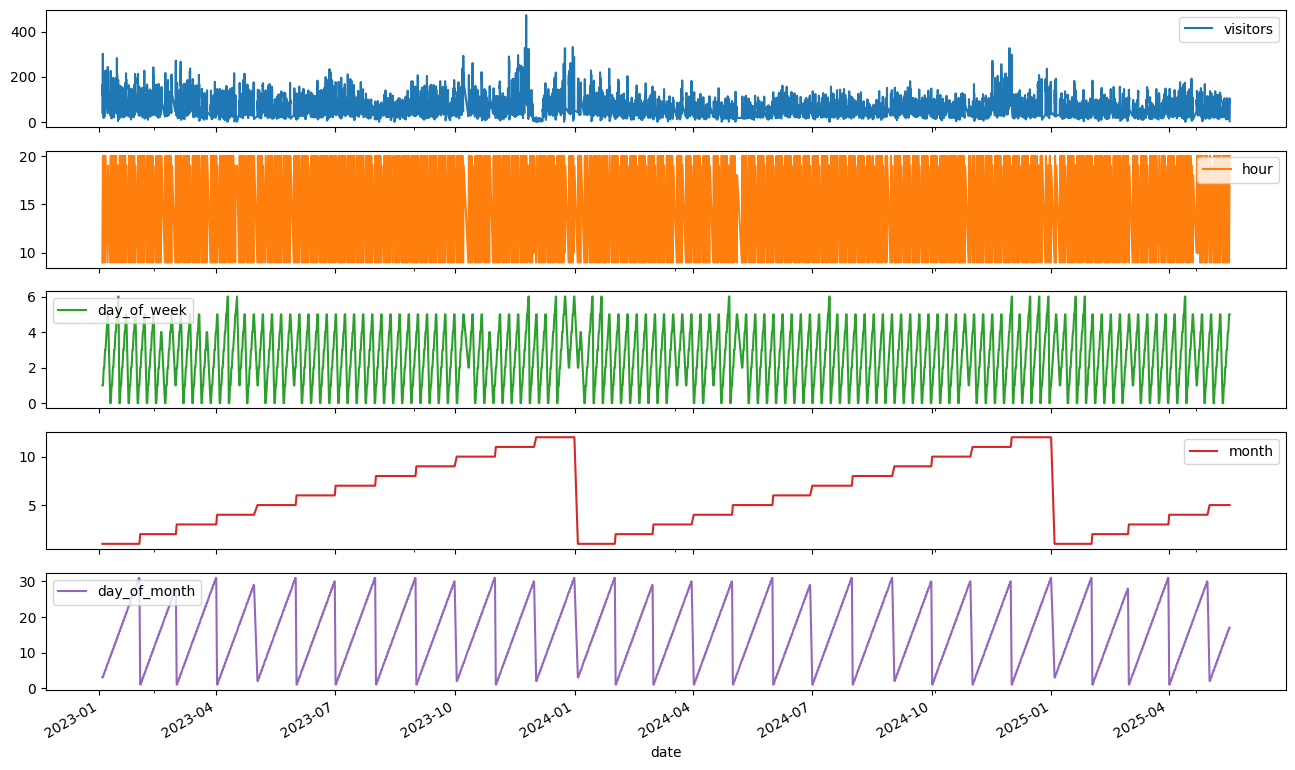

In [67]:
_ = features.plot(subplots=True, figsize=(16, 10))

* Split the dataset

In [71]:
dataset = features.values
TRAIN_SPLIT = dataset.shape[0] * 75 // 100 

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean) / data_std

invscale = lambda x: x * data_std[1] + data_mean[1]

* We create a function that will return a past window, of size `history_size`, and future data for each hour we are predicting.

In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size:step])

    return np.array(data), np.array(labels)

* We use a past history of $1440 hours$ ( = $120 days$ = $4 months$) in the past,

* and a future target up to $72 hour$ (= $12 HoursPerDay$ * $6 days$)

In [44]:
future_target = 72

past_history = 1440  # 120 days of 12 hours each history
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 
                                                 0, TRAIN_SPLIT, 
                                                 past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, 
                                             past_history,
                                             future_target, STEP)

* We read the data using a BATCH_SIZE and BUFFER_SIZE

In [46]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

* We create a function that plots the `historical data`, the `true future` and the `prediction` for the future in one plot.

In [47]:
def multi_step_plot(history, true_future, prediction, units):
    num_in = [-x for x in range(len(history))]
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out) + 1, np.array(true_future), 'go-',
             label='True Future')
    plt.plot([0, 1], [history[0, 1], true_future[0]], 'go-' )
    if prediction.any():
        plt.plot(np.arange(num_out) + 1, np.array(prediction), 'ro-',
                label='Predicted Future')
        plt.plot([0, 1], [history[0, 1], prediction[0]], '-' )
    plt.legend(loc='upper left')
    plt.xlabel('Time-Step ' + units)

* Create the LSTM Neural Network

In [50]:
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(72)
])

multi_step_model.compile(optimizer='adam', loss='mae')

* Train the model

In [52]:
EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)

history = multi_step_model.fit(train_data_multi, 
                               epochs=EPOCHS,
                               steps_per_epoch=x_train_multi.shape[0]//BATCH_SIZE,
                               validation_data=val_data_multi, 
                               validation_steps=x_val_multi.shape[0]//BATCH_SIZE,
                               callbacks=[early_stopping])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.8736 - val_loss: 0.8542
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.8617 - val_loss: 0.8409
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.8400 - val_loss: 0.7795
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.7500 - val_loss: 0.6080
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.6472 - val_loss: 0.5592
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.6006 - val_loss: 0.5392
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.5803 - val_loss: 0.5289
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.5624 - val_loss: 0.5219
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 640s 35s/step - loss: 0.5573 - val_loss: 0.5142
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.5407 - val_loss: 0.5057
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.5319 - val_loss: 0.4950
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.5239 - val_

* Plot the training and validation loss function

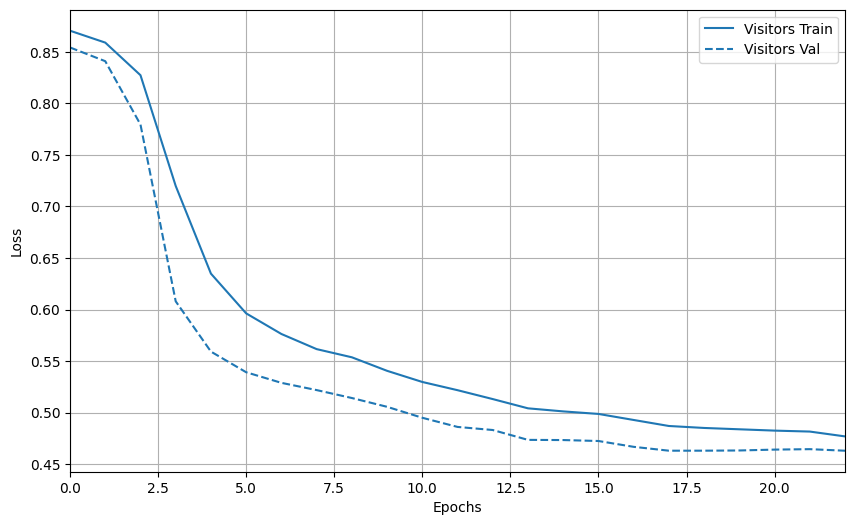

In [55]:
plotter = tfdocs.plots.HistoryPlotter(metric='loss')
plotter.plot({'Visitors': history})
#plt.ylim((0, 0.5))
plt.figure(1).set_size_inches((10, 6))

* Plot the predictions with the history window

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


2025-06-29 13:10:39.367289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


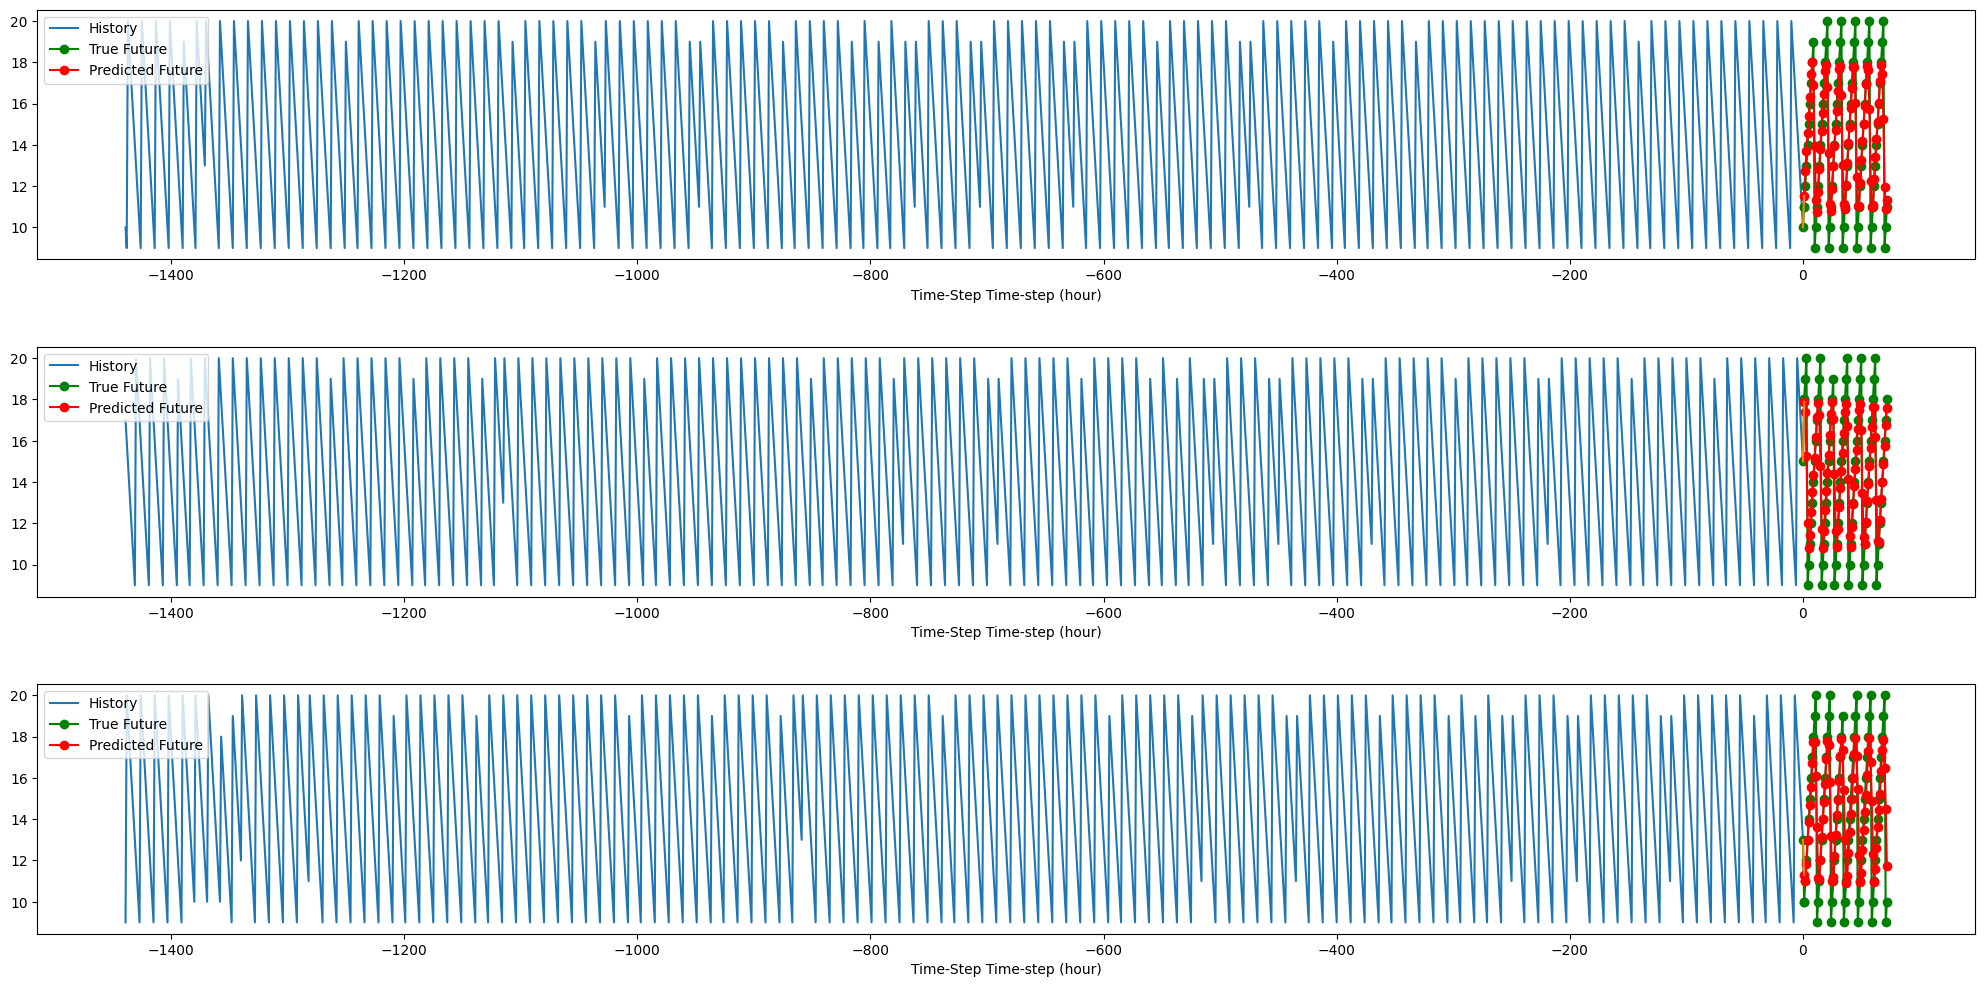

In [72]:
plt.figure(figsize=(25, 12))
for i, (x, y) in enumerate(val_data_multi.take(3)):
    plt.subplot(3, 1, (i+1))
    multi_step_plot(invscale(x[0]), invscale(y[0]), 
                    invscale(multi_step_model.predict(x)[0]), 'Time-step (hour)')
    #plt.legend(bbox_to_anchor=(1.15, 1))
plt.subplots_adjust(hspace=0.35)

* Lets take a closer look at our prediction.

In [57]:
start_index = TRAIN_SPLIT + past_history
future_dates = df['date'].iloc[start_index : start_index + future_target]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/var/folders/rc/x0844w1d6ljds746g7w33nsr0000gn/T/ipykernel_49486/3911224854.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(future_dates, invscale(multi_step_model.predict(x)[0]),'go-', color='tab:orange' ,label='Predicted')


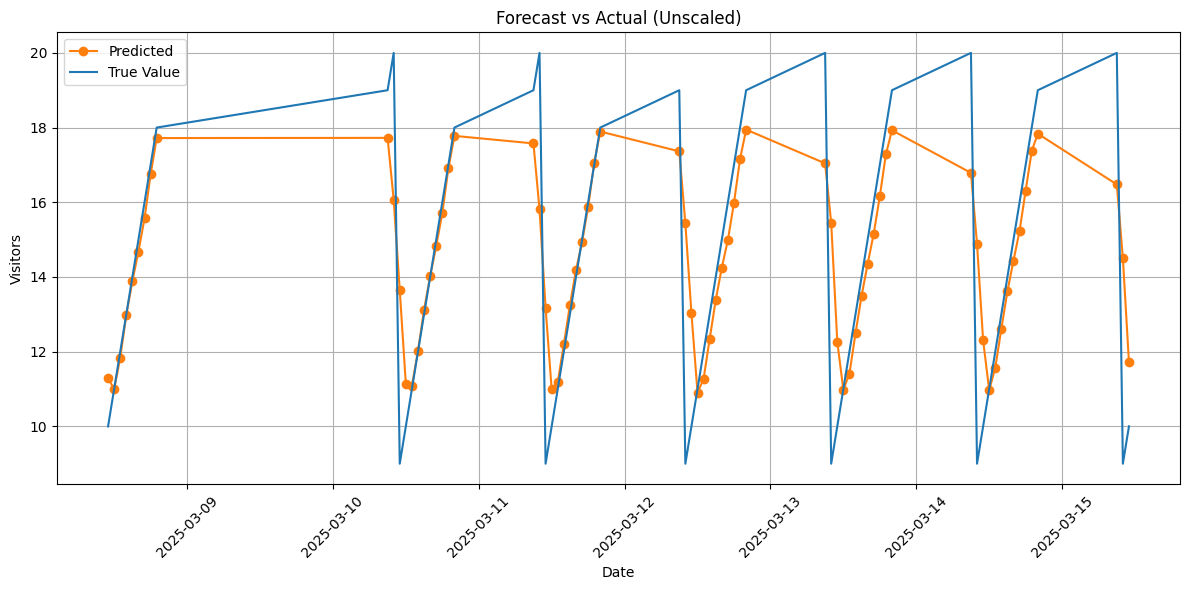

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates, invscale(multi_step_model.predict(x)[0]),'go-', color='tab:orange' ,label='Predicted')
plt.plot(future_dates, invscale(y[0]), label='True Value')
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.title("Forecast vs Actual (Unscaled)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Mean Absolute Error (MAE)

In [77]:
print(f'Mean Absolute Error (MAE): {invscale(np.mean(np.abs(multi_step_model.predict(x)[0] - y[0]))):,.2f} visitors')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Mean Absolute Error (MAE): 15.70 visitors
